## Parse

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
sys.path.append('..')
from gesetz import Gesetz

In [3]:
import pickle
with open("pickles/laws_links_topics.pickle", "rb") as fp:   # Unpickling
    Gesetz.collected_laws = pickle.load(fp)

# Build the network

In [4]:
import networkx as nx
from graph import Graph

In [5]:
Graph.set_big(Gesetz.collected_laws)

{0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14}


In [6]:
def get_subgraph(reduced):
    laws = []
    for law in reduced:
        if type(law) == Gesetz:
            laws.append(law)
        else:
            laws.append(Gesetz.collected_laws[law])

    G = nx.MultiDiGraph()
    for law in laws:
        G.add_node(law.name_short)

    for law in laws:
        for link in law.links:
            alles = False
            if alles or link.target!= None and link.target in G:
                G.add_edge(law.name_short,link.target)
    return G

In [7]:
graph = Graph.build_handpicked("GesR beck")


not found: []


In [ ]:
graph = Graph.build_topics(["GesR"])

In [9]:
graph = graph.filter_oldest(20)

In [10]:
network = graph.G_rel

In [11]:
for node in network:
    print(node)

WaStrÜbgVtrG
PachtkredG
BauFordSiG
GmbHG
GenG
VerlG
FeinGehG
HypÜberlG
FeinGehStempG
BGB
BGBEG
KErzG
TKabelVtrAG
ZVGEG
InhPapG
HGB
VVGEG
HGBEG
RHBG
ZVG


In [11]:
for node in network:
    print(node)

GenG
ZVG
TKabelVtrAG
InhPapG
BGB
ZVGEG
BGBEG
GmbHG
FeinGehG
FeinGehStempG


In [12]:
from networkx.algorithms.hierarchy import flow_hierarchy
print("Flow Hierarchy: "+str(nx.flow_hierarchy(network)))

Flow Hierarchy: 0.30452674897119336


In [13]:
#je weniger desto mehr Kreise
G = nx.DiGraph([(0,1),(1,2),(2,0)])
print("Flow Hierarchy: "+str(nx.flow_hierarchy(G)))

Flow Hierarchy: 0.0


# Find the core

In [14]:
def build_metagraph(components,graph):
    G = nx.MultiDiGraph()
    translation_of_keys = {}
    for point in components:
        if components[point] not in translation_of_keys:
            translation_of_keys[components[point]] = []
        translation_of_keys[components[point]].append(point)
    for key in translation_of_keys:
        G.add_node(key)
    for (s,t,n) in graph.edges:
        #if n==0:
            #print(s+"->"+t)
        if components[s] != components[t]:
            G.add_edge(components[s],components[t])
    return (G, translation_of_keys)

In [15]:
from networkx.algorithms.shortest_paths.generic import has_path
from networkx.algorithms.dag import lexicographical_topological_sort
from networkx.algorithms.components import strongly_connected_components



def get_topo_sort(graph,sort_key):
    comp = strongly_connected_components(graph)
    components = {}
    i = 0
    keys = {}
    for component in strongly_connected_components(graph):
        i = i+1
        for node in component:
            components[node] = i
        if i not in keys or keys[i]<sort_key(node):
            keys[i]=sort_key(node)

    (meta_graph, translation_of_keys) = build_metagraph(components,graph)
    to_return = []

    def max_key(compared_meta_node):
        to_ret = keys[compared_meta_node]
        #print("returned: "+str(to_return))
        return to_ret
    #print(keys)
    connected_components = list(reversed(list(lexicographical_topological_sort(meta_graph,max_key))))

    for index in range(len(connected_components)):
        meta_node = connected_components[index]

        to_return.append([])
        for node in components:
            if components[node] == meta_node:
                to_return[-1].append(node)
                #print(node)
    return to_return


In [16]:
from networkx.algorithms.components import weakly_connected_components

def sort_digraph(graph,sort_key):
    to_sort = []
    for comp in weakly_connected_components(graph):
        to_sort.append((len(comp),comp))
    to_sort.sort(reverse=True)
    to_return = []
    for comp in to_sort:
        #print(comp)
        sub_graph = get_subgraph(comp[1])
        to_return.append(get_topo_sort(sub_graph,sort_key))
    return to_return


In [17]:
def print_sorted_digraph(sorted):
    for weak_component in sorted:
        print()
        i=0
        for strong_component in weak_component:
            i=i+1
            #if len(strong_component)>1 or len(strong_component[0])>1:
            print(str(i)+". "+str(strong_component))

In [18]:
# by Ausfertigungsdatum
import datetime
def sort_key(node):
    return datetime.datetime.today() - Gesetz.collected_laws[node].date
sorted_di = sort_digraph(network,sort_key)
print_sorted_digraph(sorted_di)



1. ['HGB', 'GmbHG', 'BGB', 'GenG', 'BGBEG']
2. ['ZVG']
3. ['ZVGEG']
4. ['HGBEG']
5. ['VerlG']
6. ['VVGEG']
7. ['BauFordSiG']
8. ['RHBG']
9. ['KErzG']
10. ['PachtkredG']

1. ['FeinGehG']
2. ['FeinGehStempG']

1. ['WaStrÜbgVtrG']

1. ['HypÜberlG']

1. ['TKabelVtrAG']

1. ['InhPapG']


# visualize

In [23]:
components = {}
i = 0
for component in strongly_connected_components(network):
    i = i+1
    for node in component:
        components[node] = i

meta_graph, translation_of_keys = build_metagraph(components,network)

In [24]:
sorting = sort_digraph(network,sort_key)

In [25]:
flatten = lambda l: [item for sublist in l for item in sublist]
sorting = flatten(flatten(sorting))

In [26]:
ordG = nx.OrderedDiGraph()
for node in sorting:
    ordG.add_node(str(translation_of_keys[components[node]]))

In [27]:
for (s,t) in meta_graph.edges():
    ordG.add_edge(str(translation_of_keys[s]),str(translation_of_keys[t]))

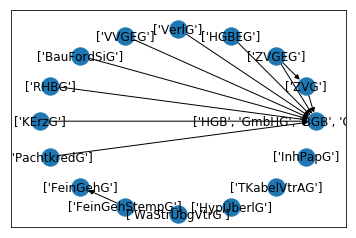

In [28]:
nx.drawing.draw_networkx(ordG,nx.shell_layout(ordG))

In [29]:
from networkx.algorithms.dag import transitive_reduction
reduced_ordG = transitive_reduction(ordG)

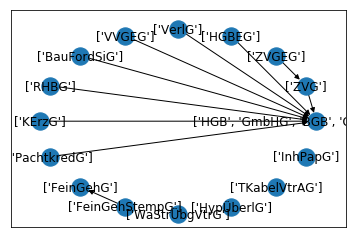

In [30]:
nx.drawing.draw_networkx(reduced_ordG,nx.shell_layout(reduced_ordG))